In [1]:
import re
from typing import List, Tuple, Any, Dict

from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict

In [2]:
def _smart_to_numeric(s: pd.Series, thresh = 0.9) -> pd.Series:
    parsed = pd.to_numeric(s, errors="coerce")
    return parsed if parsed.notna().mean() >= thresh else s

In [3]:
def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [re.sub(r"\s+", " ", c.strip()) for c in df.columns]
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = _smart_to_numeric(df[c], thresh=0.9)
    return df

In [4]:
def numeric_candidates(df: pd.DataFrame, exclude = ())-> List[str]:
    ban = set(exclude or [])
    return [c for c in df.select_dtypes(include=[np.number]).columns if c not in ban]

In [5]:
def compute_pearson(df: pd.DataFrame, target: str, exogs: List[str], top_k = None):
    """
    Correlación de Pearson (r) entre exógenas y target.
    Devuelve DataFrame ordenado por |r| con columnas: variable, r, abs_r.
    Si top_k no es None, retorna solo ese top.
    """
    rows = []
    for x in exogs:
        if x == target or x not in df.columns:
            continue
        sub = df[[x, target]].dropna()
        if sub.empty or sub[x].nunique() < 2 or sub[target].nunique() < 2:
            continue
        r = np.corrcoef(sub[x], sub[target])[0, 1]
        if np.isfinite(r):
            rows.append({"variable": x, "r": float(r), "abs_r": float(abs(r))})
    corr_df = pd.DataFrame(rows).sort_values("abs_r", ascending=False).reset_index(drop=True)
    if top_k is not None:
        corr_df = corr_df.head(top_k)
    return corr_df[["variable", "r", "abs_r"]]

In [6]:
def compute_corr_matrix_for_cols(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Matriz de correlación de Pearson (r) entre las columnas dadas.
    """
    sub = df[cols].dropna()
    if sub.shape[1] < 2 or sub.shape[0] < 2:
        return pd.DataFrame()
    return sub.corr()

In [7]:
@dataclass
class RunResult:
    target: str
    mode: str
    r2_train: float
    r2_test: float
    exog_used: List[str]
    corr_table: pd.DataFrame
    corr_matrix: pd.DataFrame
    top_poly_coeffs: pd.Series
    model: Any

In [8]:
def _fit_poly_model(
    df: pd.DataFrame,
    target: str,
    x_cols: List[str],
    *,
    degree: int = 2,
    interaction_only: bool = False,
    test_size: float = 0.2,
    random_state: int = 42,
) -> RunResult:

    if not x_cols:
        raise ValueError("No hay exógenas válidas para el modelo.")

    data = df[[target] + x_cols].dropna(subset=[target])
    X, y = data[x_cols], data[target]

    model = Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False, interaction_only=interaction_only)),
        ("lr", LinearRegression())
    ])

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(x_train, y_train)

    r2_tr = r2_score(y_train, model.predict(x_train))
    r2_te = r2_score(y_test, model.predict(x_test))

    poly = model.named_steps["poly"]
    lr = model.named_steps["lr"]
    feat_names = poly.get_feature_names_out(x_cols)

    # Serie con TODOS los coeficientes (no solo top)
    all_coefs = pd.Series(lr.coef_, index=feat_names)
    coefs_sorted = all_coefs.sort_values(key=np.abs, ascending=False)

    # Correlaciones r solo sobre las X usadas
    corr_table = compute_pearson(df, target, x_cols)
    corr_matrix = compute_corr_matrix_for_cols(df, [target] + x_cols)

    return RunResult(
        target= target,
        mode="auto" if False else "manual",
        r2_train= float(r2_tr),
        r2_test= float(r2_te),
        exog_used= x_cols,
        corr_table= corr_table,
        corr_matrix= corr_matrix,
        top_poly_coeffs= coefs_sorted,
        model= model)

In [9]:
def plot_r2_summary(summary: pd.DataFrame, title: str = "R² por modelo", show: bool = True):
    """
    Espera columns: ['target','mode','r2_train','r2_test'].
    Dibuja dos barras por modelo: R² train y test.
    """
    if summary.empty:
        print("Resumen Vacío.")
        return None, None
    labels = summary.apply(lambda r: f"{r['target']} | {r['mode']}", axis=1).tolist()
    x = np.arange(len(labels))
    w = 0.35

    fig, ax = plt.subplots(figsize=(max(6, len(labels)*0.6), 4))
    ax.bar(x - w/2, summary["r2_train"].values, width=w, label="R² train")
    ax.bar(x + w/2, summary["r2_test"].values,  width=w, label="R² test")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_ylabel("R²")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, axis="y", linestyle=":", alpha=0.6)
    plt.tight_layout()
    if show:
        plt.show()
    return fig, ax

In [10]:
def plot_multiple_corr_matrices_from_corrdfs(
    corr_dfs: List[pd.DataFrame],
    titles: List[str] | None = None,
    figsize: Tuple[int, int] = (16, 9),
    show: bool = True
):
    """
    Dibuja hasta 4 matrices de correlación en un solo plot (2x2 subplots).
    """
    def chunked(itrable, n):
        for i in range(0, len(itrable), n):
            yield itrable[i:i + n], (titles[i:i + n] if titles else None)

    figs_axes = []
    for chunk, chunk_titles in chunked(corr_dfs, 4):
        n = len(chunk)
        rows, cols = 2, 2
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        im = None
        for idx in range(4):
            ax = axes[idx]
            if idx < n and not chunk[idx].empty:
                c_df = chunk[idx]
                im = ax.imshow(c_df.values, interpolation="nearest", vmin=-1, vmax=1)
                labels = c_df.columns.tolist()
                ax.set_xticks(range(len(labels)))
                ax.set_yticks(range(len(labels)))
                ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
                ax.set_yticklabels(labels, fontsize=8)

                # anotaciones
                for i in range(len(labels)):
                    for j in range(len(labels)):
                        ax.text(j, i, f"{c_df.values[i,j]:.2f}", ha="center", va="center", fontsize=7)
                title = titles[idx] if titles and idx < len(titles) else f"{c_df.index[0]}"
                ax.set_title(title, fontsize=10)
            else:
                ax.axis("off")

        if im is not None:
            fig.subplots_adjust(right=1.5)  # dejar espacio
            cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [x, y, width, height]
            fig.colorbar(im, cax=cbar_ax)
        plt.tight_layout()

        if show:
            plt.show()
        figs_axes.append((fig, axes))
    return figs_axes

In [11]:
def play_regression_batch(
    csv_path: str,
    targets: List[str],
    exog_manual = None,
    auto_k = 8,
    drops = None,
    degree: int = 2,
    interaction_only: bool = False,
    test_size: float = 0.2,
    random_state: int = 42,
    do_prints: bool = True,
    # --- NUEVO FLAG ---
    plot_r2_summary_flag: bool = False,
    plot_corr_matrix_flag: bool = False,
) -> Dict[str, Any]:
    
    df = load_and_clean(csv_path)

    for t in targets:
        assert t in df.columns, f"'{t}' no está en el CSV."

    drops = drops or []
    cand_global = numeric_candidates(df, exclude=drops)

    results: List[RunResult] = []
    results_meta = []
    
    for target in targets:
        # --- AUTO-K ---
        if auto_k:
            cand = [c for c in cand_global if c != target]
            corr_all = compute_pearson(df, target, cand)
            x_auto = corr_all.head(auto_k)["variable"].tolist()
            run_id = f"{target}__AUTO_K={auto_k}"
            if do_prints:
                print(f"\n>>> {run_id}: {len(x_auto)} exógenas seleccionadas por |r|")
            res_auto = _fit_poly_model(
                df, target, x_auto,
                degree=degree, interaction_only=interaction_only,
                test_size=test_size, random_state=random_state,
            )
            res_auto.mode = f"auto_k={auto_k}"
            results.append(res_auto)
            results_meta.append({"target": res_auto.target, "mode": res_auto.mode, 
                                 "r2_train": res_auto.r2_train, "r2_test": res_auto.r2_test})

        # --- MANUAL ---
        if exog_manual:
            exog_valid = [c for c in exog_manual if c in df.columns and c in cand_global and c != target]
            run_id = f"{target}__MANUAL"
            if do_prints:
                print(f"\n>>> {run_id}: {len(exog_valid)} exógenas (set común)")
            res_manual = _fit_poly_model(
                df, target, exog_valid,
                degree=degree, interaction_only=interaction_only,
                test_size=test_size, random_state=random_state,
            )
            res_manual.mode = "manual"
            results.append(res_manual)
            results_meta.append({"target": res_manual.target, "mode": res_manual.mode,
                            "r2_train": res_manual.r2_train, "r2_test": res_manual.r2_test})

    summary = pd.DataFrame(results_meta).sort_values(["target","mode"]).reset_index(drop=True)
    if do_prints:
        print("\n" + "="*74)
        print("RESUMEN COMPARATIVO")
        try:
            display(summary.style.format({"r2_train": "{:.3f}", "r2_test": "{:.3f}"}))
        except:
            print(summary)

    if plot_r2_summary_flag:
        plot_r2_summary(summary)

    if plot_corr_matrix_flag:
        corr_dfs = [r.corr_matrix for r in results if getattr(r, "corr_matrix", None) is not None]
        titles = [f"{r.target} | {r.mode}" for r in results]

        corr_dfs_filtered = [c for c in corr_dfs if not c.empty]
        titles_filtered = [t for c, t in zip(corr_dfs, titles) if not c.empty]
        if corr_dfs_filtered:
            plot_multiple_corr_matrices_from_corrdfs(corr_dfs_filtered, titles_filtered)

    return {"summary": summary, "results": results}


>>> Life expectancy__AUTO_K=8: 8 exógenas seleccionadas por |r|

>>> Life expectancy__MANUAL: 8 exógenas (set común)

>>> infant deaths__AUTO_K=8: 8 exógenas seleccionadas por |r|

>>> infant deaths__MANUAL: 8 exógenas (set común)

>>> Adult Mortality__AUTO_K=8: 8 exógenas seleccionadas por |r|

>>> Adult Mortality__MANUAL: 8 exógenas (set común)

RESUMEN COMPARATIVO


,target,mode,r2_train,r2_test
0,Adult Mortality,auto_k=8,0.545,0.559
1,Adult Mortality,manual,0.484,0.524
2,Life expectancy,auto_k=8,0.897,0.895
3,Life expectancy,manual,0.855,0.849
4,infant deaths,auto_k=8,0.902,0.951
5,infant deaths,manual,0.756,0.859


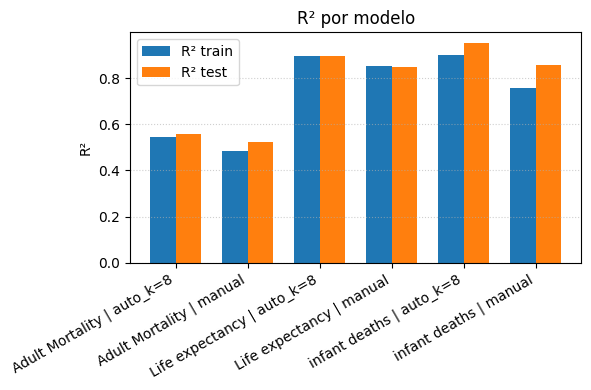

C:\Users\arbed\AppData\Local\Temp\ipykernel_29576\863914577.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


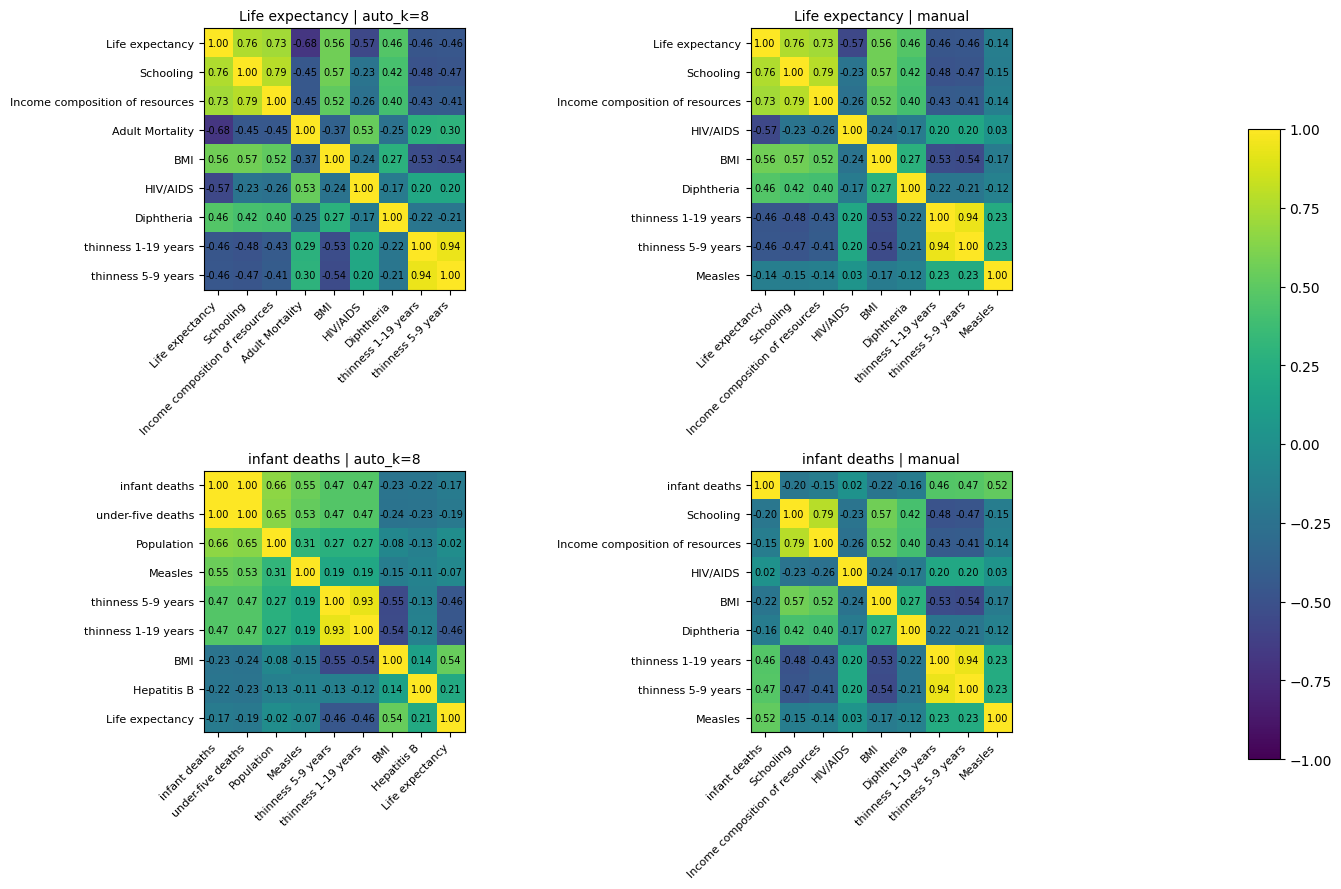

C:\Users\arbed\AppData\Local\Temp\ipykernel_29576\863914577.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


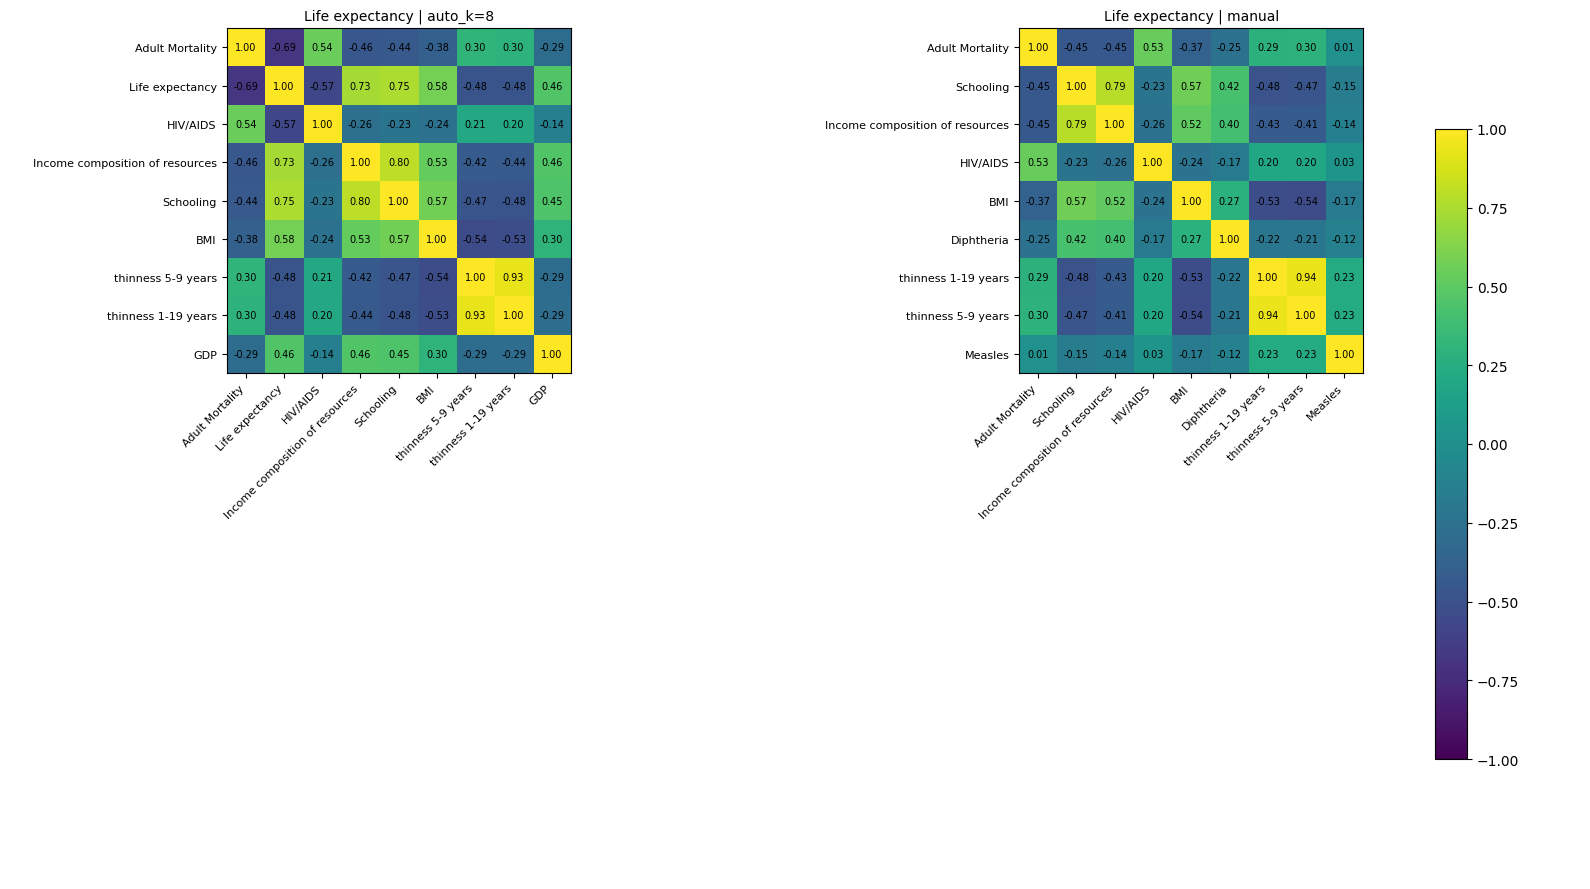

In [12]:
out = play_regression_batch(
    csv_path=r"C:\Users\arbed\Downloads\Life Expectancy Data.csv",
    targets=["Life expectancy", "infant deaths", "Adult Mortality"],
    exog_manual=["Schooling","Income composition of resources","HIV/AIDS","BMI","Diphtheria","thinness 1-19 years","thinness 5-9 years","Measles"],
    auto_k=8,
    degree=2,
    interaction_only=False,
    do_prints=True,
    # gráficos:
    plot_r2_summary_flag=True,
    plot_corr_matrix_flag=True,
)